In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

## Initializing the Model

In [248]:
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.MaxPooling2D(), 
    #layers.Dense(256, activation='relu'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 2560)        0         
 g2D)                                                            
                                                                 
Total params: 64097687 (244.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [265]:
import pickle
with open('Processed_data_RGB_224x224.pkl', 'rb') as file:
    data = pickle.load(file)

ADG_im = list(data.image)
ADG_lb = list(data.label)

## Data Augmentation

In [266]:
ADG_im = list(data.image)
ADG_lb = list(data.label)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


image_arrays = np.array([np.array(img) for img in data['image']])

batch_size = 32
augmented_generator = datagen.flow(
    x=image_arrays,
    y=data.label,  
    batch_size=batch_size,
    shuffle=True, 
)

num_batches = 100 
for kl in range(num_batches):
    batch_images, batch_labels = augmented_generator.next()
    for i in range(batch_size):
        
        ADG_im.append(batch_images[i])
        ADG_lb.append(batch_labels[i])

In [271]:
ADG_im = np.asarray(ADG_im)

In [272]:
ADG_im.shape

(6613, 224, 224, 3)

In [275]:
pd.Series(ADG_lb).value_counts()

-1.0    5875
 1.0     738
Name: count, dtype: int64

In [276]:
x_train, x_test, y_train, y_test = train_test_split(ADG_im, ADG_lb, test_size=0.3,random_state=666)

In [277]:
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))

In [278]:
features = model.predict(x_train)
x_test_features = model.predict(x_test)

62/62 [==============================] - 98s 2s/step


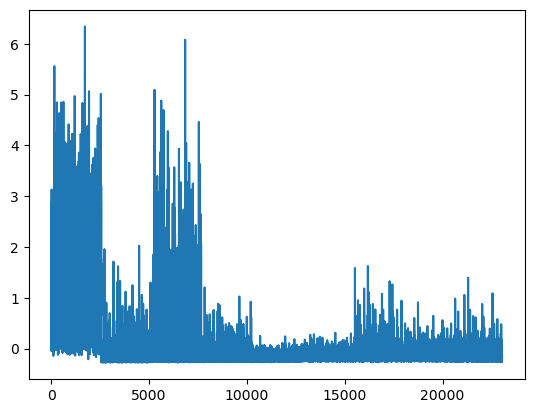

In [281]:
features = features.reshape((features.shape[0], -1))
x_test_features = x_test_features.reshape((x_test_features.shape[0], -1))
plt.plot(features[127])

## KNN Classifier

In [282]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [287]:
knn_model = KNeighborsClassifier(n_neighbors=7) 
knn_model.fit(features, y_train)
y_pred = knn_model.predict(x_test_features)
f1_score(y_test, y_pred, average='weighted')

0.8915889214944248

In [286]:
fs =[]
for i in range(1,10):
    knn_model = KNeighborsClassifier(n_neighbors=i) 
    knn_model.fit(features, y_train)
    y_pred = knn_model.predict(x_test_features)
    fs.append(f1_score(y_test, y_pred, average='weighted'))
print(fs)

[0.8730743423390875, 0.8690706817259011, 0.8811985175104898, 0.8793280597366113, 0.8910818385947947, 0.8873448878687441, 0.8915889214944248, 0.8837412255948077, 0.8897883311311033]


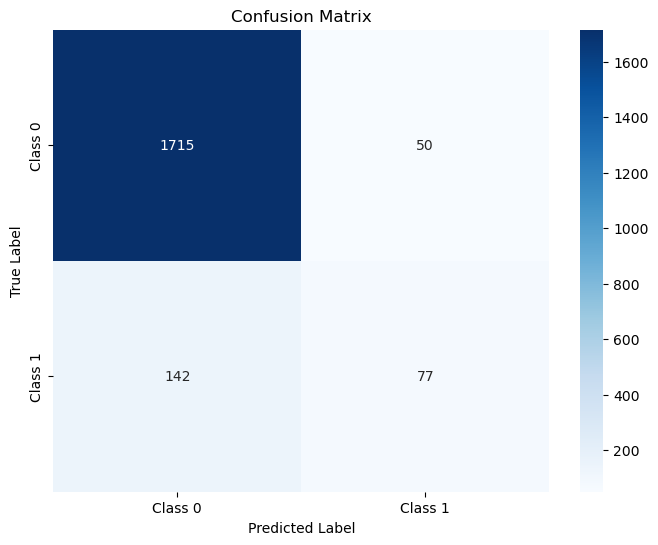

In [289]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## XGBoost Classifier

In [300]:
import xgboost as xgb

y_train_labels = [1 if p > 0 else 0 for p in y_train]
y_test_labels = [1 if p > 0 else 0 for p in y_test]
dtrain = xgb.DMatrix(features, label = y_train_labels)
dtest = xgb.DMatrix(x_test_features)

In [305]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'learning_rate': 0.05,
    'n_estimators': 100,
    'subsample': 0.6,
    'colsample_bytree': 0.6
}

model = xgb.train(params, dtrain, num_boost_round=100)

y_pred_prob = model.predict(dtest)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_prob]

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:53:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [306]:
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred))
f1_score(y_test_labels, y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1765
           1       0.66      0.35      0.46       219

    accuracy                           0.91      1984
   macro avg       0.79      0.66      0.70      1984
weighted avg       0.89      0.91      0.90      1984



0.8952968565771151